# Problem Session 5

The problems in this notebook will cover the content covered in our Inference I lectures including:
- Hypothesis Testing
- Confidence Intervals
- Linear Regression Inference

#### 1. The dangers of early peeking in A/B testing

One especially common use of hypothesis testing in data science is "A/B testing".

Many companies which prioritize data informed decision making have very mature A/B testing platforms to trial changes before adoption.  Here is an example of an A/B test which comes from the book "Trustworthy Online Controlled Experiments" by Kohavi, Tang and Xu:

Someone at your company proposes implementing a coupon code system.  To rapidly get some idea of the potential impacts even *before* implementing the complete system you decide to implement the following A/B test:  for a period of two weeks you will show half of your customers your standard checkout page (the "control group"), and you will show the other half a new checkout page which has a coupon code box (the "treatment group"). Since there are no coupon codes in existence yet, putting anything in the box will simply display "invalid code" and otherwise do nothing.

You will monitor how customers interact with the coupon code box (how many people click on it, enter anything into it, enter one or more attempted codes, etc), how long they stay on the checkout page in the control and treatment group, what fraction of customers who make it to the checkout page who actually complete their purchase, and the revenue per customer who made it to the checkout page.

In this example, the mere presence of a coupon code box significantly reduced revenue per customer with an effect size large enough to scuttle the project!

It is common (but ill advised) for companies to **continuously** monitor such experiments and stop early when a significant result is obtained in either direction.  The reasoning is that we would not want to continue a disastrous experiment for the full planned time (e.g.  hardly anyone checks out after being presented with the coupon code box), and we would likewise not want to miss out on the benefits by **not** implementing a positive experiment as soon as possible.

In this exercise we will see why early stopping is such a bad idea through simulation.

##### a)

Finish the definition of the following function:

In [27]:
import numpy as np
import pandas as pd

def simulate_data(control_mean, treatment_mean, scale, size):
    '''
    Draws from two normal distributions with the same scale and different means

    Args:
        control_mean:  the mean of the control group
        treatment_mean: the mean of the treatment group
        scale: the common standard deviation of both groups
        size: the shape of both outputs
    
    returns:
        The tuple (control_data, treatment_data)        
    '''
    control_data = np.random.normal(loc = control_mean, scale = scale, size = size)
    treatment_data = np.random.normal(loc = treatment_mean, scale = scale, size = size)
    return (control_data, treatment_data)


# Note: for the probabilistic checks below, the probability of both false positive and negatives are so low as to be effectively zero
# It is a fun little puzzle to estimate these probabilities.
assert(simulate_data(3,3,1,(10,2))[0].shape == (10,2)), "control_data does not have the correct shape"
assert(simulate_data(3,3,1,(10,2))[1].shape == (10,2)), "treatment_data does not have the correct shape"
assert(np.abs(simulate_data(0,3,1,(1000))[0].mean()) < 1  ), "control_data does not have the correct mean"
assert(np.abs(simulate_data(0,3,1,(1000))[1].mean() - 3) < 1  ), "treatment_data does not have the correct mean"
assert(np.abs(simulate_data(0,3,1,(1000))[0].std() - 1) < 0.5 ), "control_data does not have the correct standard deviation"
assert(np.abs(simulate_data(0,3,1,(1000))[1].std() - 1) < 0.5 ), "treatment_data does not have the correct standard deviation"

##### b)

Read the following documentation:

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html

Use the `ttest_ind` to finish writing the following two functions:

In [28]:
from statsmodels.stats.weightstats import ttest_ind

def no_early_peeking_results(control_data, treatment_data):
    '''
    Returns the p-value of the t-test comparing the two group means.
    '''
    p_value = ttest_ind(control_data, treatment_data)[1]
    return p_value

assert(no_early_peeking_results([1,2,3], [4,5,6]) == 0.021311641128756727)

In [29]:
def early_peeking_results(control_data, treatment_data, alpha):
    '''
    Runs a t-test on each initial segment of the control and treatment data.

    Args:
        alpha: the threshold for significance.
        
    Returns: 
        (p_value, nobs)
        p_value: the p-value of the first significant such test
        nobs: the number of observations in that test
    
    Example:  
        early_peeking_results([1,2,2,2,2,2], [4,5,5,5,5,5], 0.05)
        Should run a t-test on 
            [1,2], [4,5]
            [1,2,2], [4,5,5]
            [1,2,2,2], [4,5,5,5]
            etc
        when a significant p-value is found it will output
        that p-value and the length of the control group for that test.
    '''
    p_value = 1
    nobs = 2
    while p_value > alpha and nobs < len(control_data):
        p_value = ttest_ind(control_data[:nobs], treatment_data[:nobs])[1]
        nobs += 1
    return p_value, nobs

assert(early_peeking_results([1,2,2,2,2,2], [4,5,5,5,5,5], 0.05)[0] == 0.0031255892524457277)
assert(early_peeking_results([1,2,2,2,2,2], [4,5,5,5,5,5], 0.05)[1] == 4)

##### c)

We will now see the impact of early peeking on the false positive rate.

By setting both the control and training mean to 0, and $\alpha = 0.05$ for the threshold for significance, we should expect to see a false positive rate of roughly $0.05$.  We will see that early peeking wildly inflates the false positive rate!

This is bad news for our company, because we will be mislead into thinking that our treatment has a significant effect (in either direction) when there really is no effect at all.

In [30]:
def comparing_procedures(control_mean = 0, 
                            treatment_mean = 0, 
                            scale = 1, 
                            size = 1000, 
                            num_simulations = 100, 
                            alpha = 0.05):
    '''
    Simulates data from both control and treatment groups.
    Returns a tuple of the following self explanatory variables:
        no_early_peeking_false_positives of type int
        early_peeking_false_positives of type int
        early_peeking_nobs of type list(int)
    '''                
    no_early_peeking_false_positives = 0
    early_peeking_false_positives = 0
    early_peeking_nobs = []

    for i in range(100):
        control_data, treatment_data = simulate_data(control_mean,treatment_mean,scale,size)
        no_early_peeking_p_value = no_early_peeking_results(control_data, treatment_data)
        early_peeking_p_value, nobs = early_peeking_results(control_data, treatment_data, alpha)
        if no_early_peeking_p_value < 0.05:
            no_early_peeking_false_positives += 1
        if early_peeking_p_value < 0.05:
            early_peeking_false_positives += 1
        early_peeking_nobs.append(nobs)

    early_peeking_nobs = np.array(early_peeking_nobs)

    return (no_early_peeking_false_positives, early_peeking_false_positives, early_peeking_nobs)

In [31]:
num_simulations = 100
size = 1000
(no_early_peeking_false_positives, early_peeking_false_positives, early_peeking_nobs) = comparing_procedures(num_simulations=num_simulations, size = size)
print(f"The number of false positives with no early peeking is {no_early_peeking_false_positives} out of {num_simulations}")
print(f"The number of false positives with early peeking is {early_peeking_false_positives} out of {num_simulations}")
print(f"The number of observations to reach those false positives (out of {size}) were \n {early_peeking_nobs[early_peeking_nobs != 1000]}")

The number of false positives with no early peeking is 4 out of 100
The number of false positives with early peeking is 44 out of 100
The number of observations to reach those false positives (out of 1000) were 
 [  3  10  77   3  31  77 335  61 178 180 235 560  30  21   4  35   5   3
  51  29 686   5  81 128  55 188  20 406   4   4  68  89 438   4  23 335
   5  25  33   4  33  12   7  53]


#### 2. Confidence Intervals and Linear Regression Coefficients


In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

#### a) Problem introduction

The following [dataset](https://dasl.datadescription.com/datafile/bodyfat/) comes from the [Data and Story Library](https://dasl.datadescription.com/). 

Our target variable is `Pct.BF` which stands for "percent body fat".

Age is given in years, weight is given in pounds, and all other measurements are given in inches.

In [33]:
bf = pd.read_csv('../../data/bodyfat.csv')
bf.head()

,Pct.BF,Age,Weight,Height,Neck,Chest,Abdomen,Waist,Hip,Thigh,Knee,Ankle,Bicep,Forearm,Wrist
0,12.3,23,154.25,67.75,36.2,93.1,85.2,33.543307,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,6.1,22,173.25,72.25,38.5,93.6,83.0,32.677165,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,25.3,22,154.00,66.25,34.0,95.8,87.9,34.606299,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,10.4,26,184.75,72.25,37.4,101.8,86.4,34.015748,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,28.7,24,184.25,71.25,34.4,97.3,100.0,39.370079,101.9,63.2,42.2,24.0,32.2,27.7,17.7


This table does not include [Body Mass Index](https://en.wikipedia.org/wiki/Body_mass_index), but we can calculate it from the data.

Add a new column `BMI` which records this.

In [34]:
bf['BMI'] = (bf.Weight/2.2)/(bf.Height/39.4)**2

The name of the target variable `Pct.BF` is a bit problematic for `statsmodels` because of the period.  Change the name of that column to `BFP`.

In [35]:
bf = bf.rename(columns={'Pct.BF':'BFP'})

#### b)  Train/Test Split

One of the reasons that we have a reproducibility crisis in several fields of science is that researchers test multiple hypotheses on their full dataset and only report the statistically significant findings.  As you should know, assuming that the null hypotheses are actually all true you will find one "significant" result for every $20$ things you try.

Even without deliberate "p-hacking" one can still be led astray as the article [The garden of forking paths](http://www.stat.columbia.edu/%7Egelman/research/unpublished/p_hacking.pdf) by Gelman and Loken so convincingly argues.  

One way to combat this is by conducting a replication study, but that can be expensive.

Alternatively can conduct your own replication study by splitting your data in half.  Experiment to your hearts content on the training data.  Find whatever interesting potential associations you like without worrying.  Then test one of these hypotheses on your testing set.  The downside is that your study is less powerful since you have access to only half the data.  The upside is that the data used to generate your research hypothesis is not the same data which you use to test your hypothesis (a very good thing).

For these reasons, make a 50/50 train test split of the bodyfat data:

In [36]:
from sklearn.model_selection import train_test_split

bf_train, bf_test = train_test_split(bf, test_size = 0.2, random_state = 216)

#### c) Exploring possible associations

Fit the following regression models:

In [45]:
# full_model uses BMI, Waist, and Abdomen as features
full_model = smf.ols('BFP ~ BMI + Waist + Abdomen', data=bf_train).fit()

# waist_model uses Waist as the only feature
waist_model = smf.ols('BFP ~ Waist', data=bf_train).fit()

# bmi_model uses BMI as the only feature
bmi_model = smf.ols('BFP ~ BMI', data=bf_train).fit()

# abdomen_model uses BMI as the only feature
abdomen_model = smf.ols('BFP ~ Abdomen', data=bf_train).fit()

Look at the summary of each model.  Do they tell a consistent story?

For each model discuss the following with your group:

1. Describe *precisely* what is the meaning of the $p$-value listed for each feature.
2. Describe *precisely* what is the meaning of the $95\%$ confidence interval listed for each feature.
2. How can it be that a feature is considered significant by one model and not by another?
3. Can you explain any unusual findings? 

In [46]:
full_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    BFP   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     131.6
Date:                Fri, 27 Sep 2024   Prob (F-statistic):           9.95e-47
Time:                        12:57:53   Log-Likelihood:                -600.87
No. Observations:                 200   AIC:                             1210.
Df Residuals:                     196   BIC:                             1223.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -42.3831      3.156    -13.431      0.000     -48.606     -36.160
BMI           -0.1586      0.258     -0.615      0.539      -0.667       0.350
Waist       4.271e+05   1.28e+06      0.333      0.739    -2.1e+06    2.96e+06
Abdomen    -1.682e+05   5.05e+05     -0.333      0.739   -1.16e+06    8.27e+05
==============================================================================
Omnibus:                        4.801   Durbin-Watson:                   2.138
Prob(Omnibus):                  0.091   Jarque-Bera (JB):                2.842
Skew:                           0.018   Prob(JB):                        0.241
Kurtosis:                       2.417   Cond. No.                     4.06e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.28e-11. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [47]:
waist_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    BFP   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.666
Method:                 Least Squares   F-statistic:                     397.2
Date:                Fri, 27 Sep 2024   Prob (F-statistic):           3.31e-49
Time:                        12:57:53   Log-Likelihood:                -601.16
No. Observations:                 200   AIC:                             1206.
Df Residuals:                     198   BIC:                             1213.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -42.0395      3.084    -13.633      0.000     -48.120     -35.959
Waist          1.6865      0.085     19.929      0.000       1.520       1.853
==============================================================================
Omnibus:                        5.417   Durbin-Watson:                   2.147
Prob(Omnibus):                  0.067   Jarque-Bera (JB):                3.063
Skew:                           0.004   Prob(JB):                        0.216
Kurtosis:                       2.394   Cond. No.                         324.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [48]:
bmi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    BFP   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                     235.8
Date:                Fri, 27 Sep 2024   Prob (F-statistic):           1.44e-35
Time:                        12:57:53   Log-Likelihood:                -632.78
No. Observations:                 200   AIC:                             1270.
Df Residuals:                     198   BIC:                             1276.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -27.2273      3.039     -8.959      0.000     -33.220     -21.234
BMI            1.8272      0.119     15.357      0.000       1.593       2.062
==============================================================================
Omnibus:                        4.896   Durbin-Watson:                   2.220
Prob(Omnibus):                  0.086   Jarque-Bera (JB):                2.933
Skew:                          -0.055   Prob(JB):                        0.231
Kurtosis:                       2.417   Cond. No.                         191.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [49]:
abdomen_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    BFP   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.666
Method:                 Least Squares   F-statistic:                     397.2
Date:                Fri, 27 Sep 2024   Prob (F-statistic):           3.31e-49
Time:                        12:57:53   Log-Likelihood:                -601.16
No. Observations:                 200   AIC:                             1206.
Df Residuals:                     198   BIC:                             1213.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -42.0395      3.084    -13.633      0.000     -48.120     -35.959
Abdomen        0.6640      0.033     19.929      0.000       0.598       0.730
==============================================================================
Omnibus:                        5.417   Durbin-Watson:                   2.147
Prob(Omnibus):                  0.067   Jarque-Bera (JB):                3.063
Skew:                           0.004   Prob(JB):                        0.216
Kurtosis:                       2.394   Cond. No.                         822.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Use an F-test to compare the full model to the waist, abdomen, and bmi models.  What is the precise meaning of the $p$-value of each test? 

In [50]:
# Perform the F-test
f_test_waist = full_model.compare_f_test(waist_model)
f_test_bmi = full_model.compare_f_test(bmi_model)
f_test_abdomen = full_model.compare_f_test(abdomen_model)


print("p-value of full compared to waist model:", f_test_waist[1])
print("p-value of full compared to abdomen model:", f_test_abdomen[1])
print("p-value of full compared to BMI model:", f_test_bmi[1])


p-value of full compared to waist model: 0.7518477300269533
p-value of full compared to abdomen model: 0.7518472907056596
p-value of full compared to BMI model: 2.6324358672235737e-14


If you have not already, make a plot of `waist` against `abdomen` to help explain what we have been seeing:

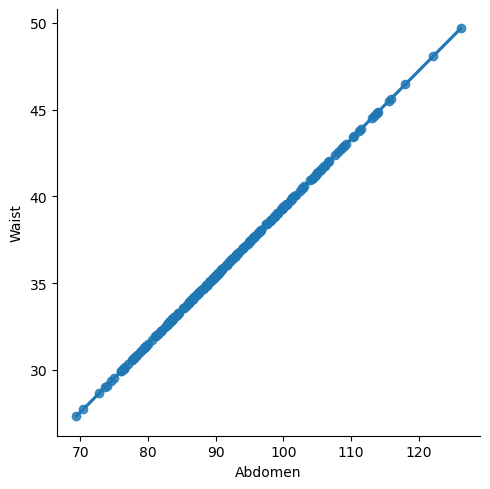

In [51]:
sns.lmplot(data=bf, x= 'Abdomen', y = 'Waist')
plt.show()

#### d)  Final model evaluation on testing set.

Let's choose the waist model as our final model.  Fit the model to the testing data and look at the summary.  Discuss with your group.

In [54]:
final_model = smf.ols('BFP ~ Waist', data=bf_test).fit()
final_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    BFP   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     148.1
Date:                Fri, 27 Sep 2024   Prob (F-statistic):           2.81e-16
Time:                        13:02:03   Log-Likelihood:                -136.06
No. Observations:                  50   AIC:                             276.1
Df Residuals:                      48   BIC:                             279.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -47.7366      5.515     -8.655      0.000     -58.826     -36.647
Waist          1.8132      0.149     12.169      0.000       1.514       2.113
==============================================================================
Omnibus:                        0.929   Durbin-Watson:                   2.373
Prob(Omnibus):                  0.628   Jarque-Bera (JB):                0.999
Skew:                           0.280   Prob(JB):                        0.607
Kurtosis:                       2.591   Cond. No.                         385.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### e) Confidence and prediction intervals

Make a graph which includes:

1. A scatterplot of the data
2. The confidence interval for the predicted mean response.
3. The prediction interval for the response.

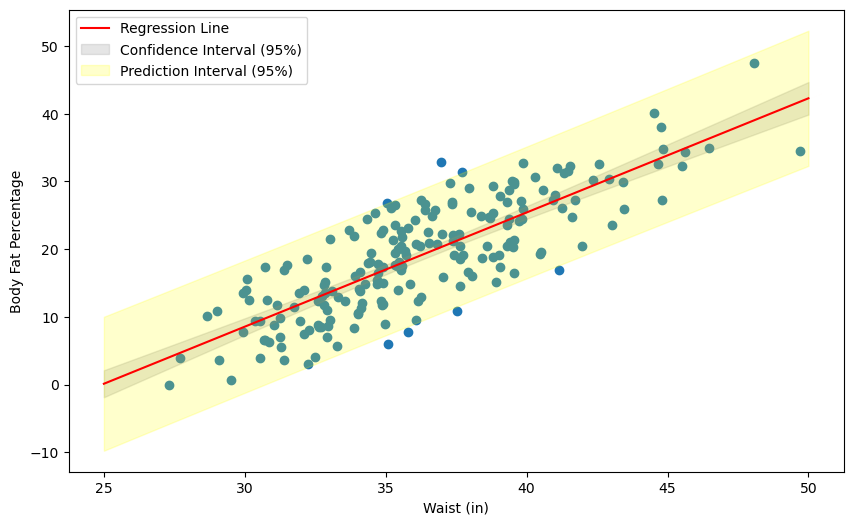

In [53]:
xs = np.linspace(25, 50)

# Create a DataFrame with the same structure as the one used for training
df_xs = pd.DataFrame({'Waist': xs})

# Get predictions using the new DataFrame
predictions = waist_model.get_prediction(df_xs)

pred_summary_frame = predictions.summary_frame(alpha=0.05)

# Extract values
mean_pred = pred_summary_frame['mean']
mean_ci_lower = pred_summary_frame['mean_ci_lower']
mean_ci_upper = pred_summary_frame['mean_ci_upper']
obs_ci_lower = pred_summary_frame['obs_ci_lower']
obs_ci_upper = pred_summary_frame['obs_ci_upper']

# Plotting
plt.figure(figsize=(10, 6))

plt.scatter(bf_train.Waist, bf_train.BFP)

plt.plot(xs, mean_pred, 'r-', label='Regression Line')
plt.fill_between(xs, mean_ci_lower, mean_ci_upper, color='gray', alpha=0.2, label='Confidence Interval (95%)')
plt.fill_between(xs, obs_ci_lower, obs_ci_upper, color='yellow', alpha=0.2, label='Prediction Interval (95%)')
plt.xlabel('Waist (in)')
plt.ylabel('Body Fat Percentage')
plt.legend()
plt.show()

Discuss the precise meanings of these confidence and prediction intervals with your group!